# Application Example of RIANN on the BROAD Dataset

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

Download the data of the BROAD dataset (https://doi.org/10.3390/data6070072). The notebook assumes, that the `data_hdf5` Folder is inside of the working directory.

In [2]:
#!wget https://depositonce.tu-berlin.de/bitstream/11303/13238/2/broad.zip
#!unzip broad.zip

Load the reference orientation, accelerometer, gyroscope and sampling-rate values of a measurement.

In [3]:
#!pip install h5py
import h5py
with h5py.File('data_hdf5/01_undisturbed_slow_rotation_A.hdf5','r') as f:
    acc = f['imu_acc'][:]
    gyr = f['imu_gyr'][:]
    ref_quat = f['opt_quat'][:]
    fs = f.attrs['sampling_rate']

Use RIANN to estimate the attitude of the IMU

In [4]:
from riann.riann import RIANN
riann = RIANN()
est_quat = riann.predict(acc,gyr,fs)
est_quat.shape

(56940, 4)

Define the attitude error metric for the final evaluation

In [5]:
def relativeQuat(q1, q2):
    """quat1*inv(quat2)"""

    o1 =  q1[..., 0] * q2[..., 0] + q1[..., 1] * q2[..., 1] + q1[..., 2] * q2[..., 2] + q1[..., 3] * q2[..., 3]
    o2 = -q1[..., 0] * q2[..., 1] + q1[..., 1] * q2[..., 0] - q1[..., 2] * q2[..., 3] + q1[..., 3] * q2[..., 2]
    o3 = -q1[..., 0] * q2[..., 2] + q1[..., 1] * q2[..., 3] + q1[..., 2] * q2[..., 0] - q1[..., 3] * q2[..., 1]
    o4 = -q1[..., 0] * q2[..., 3] - q1[..., 1] * q2[..., 2] + q1[..., 2] * q2[..., 1] + q1[..., 3] * q2[..., 0]

    return np.stack([o1,o2,o3,o4],axis=-1)

def safe_acos_double(t,eps = 1e-16):
    '''numericaly stable variant of arcuscosine, uses 64bit floats for internal computation for increased accuracy'''
    return np.float32(np.arccos(np.clip(np.float64(t),-1.0 + eps, 1.0 - eps)))

def attitudeAngleDeg(q1,q2):
    '''the attitude error between to quaternions in degree'''
    q = relativeQuat(q1,q2)
    
    return 2*safe_acos_double(np.sqrt(q[..., 3]**2 + q[..., 0]**2))/np.pi*180

Plot the attitude error of every time step

Text(0, 0.5, 'attitude error [°]')

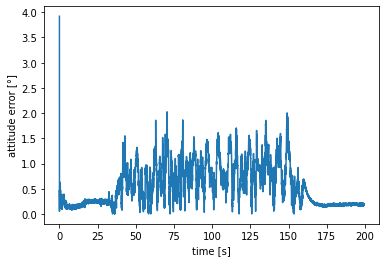

In [6]:
plt.figure()
x = np.linspace(0,ref_quat.shape[0]/fs,ref_quat.shape[0])
plt.plot(x,attitudeAngleDeg(est_quat,ref_quat))
plt.xlabel('time [s]')
plt.ylabel('attitude error [°]')